# Regression Model Experiment

1. Models: xgbregressor
2. metrics: RMSE, MAE, MAPE, RMSLE




In [165]:
import pandas as pd
from src.func_data_diagnosis import *
from src.func_data_engineering import *
from src.func_model_tracker import *
from src.func_modelling import *
import matplotlib.pyplot as plt
from xgboost import XGBRegressor,plot_importance,plot_tree,to_graphviz

%load_ext autoreload
%autoreload
%cd C:\Users\tyler\repos\airbnb-forecast

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
C:\Users\tyler\repos\airbnb-forecast


## 1. Read features
Set up a connection

In [2]:
engine = connect_my_db("secrets/db_string")

Read the tables from PostgreSQL

In [3]:
df_list = read_table(engine, "FS_LIST")
df_cal = read_table(engine, "FS_CAL_MONTHLY")
df_host = read_table(engine, "FS_HOST")
df_rev = read_table(engine, "FS_REVIEW")

# Merge the features together to become main dataset

df_list['YEAR_MONTH']=df_list.LAST_SCRAPED.str[:7]
df_data = df_list.merge(df_cal, left_on=['ID','YEAR_MONTH'], right_on = ['LISTING_ID','YEAR_MONTH'])
df_data = df_data.merge(df_host, left_on=['ID','HOST_ID','LAST_SCRAPED'], right_on = ['ID','HOST_ID','LAST_SCRAPED'])
df_data = df_data.merge(df_rev,on = ['ID', 'LAST_SCRAPED'] )


# engineering, todo: put in run
df_data['YEAR'] = df_data.LAST_SCRAPED.str[:4].astype(int)
df_data['MONTH'] = df_data.LAST_SCRAPED.str[5:7].astype(int)

# 2. Train, valifdation, test data split

In [142]:
# for op
newhost = ['ACCOMMODATES','BATHROOMS','BEDROOMS'
    ,'GUESTS_INCLUDED'
    ,'ADJUSTED_PRICE'
    ,'HOST_LISTINGS_COUNT','HOST_HAS_PROFILE_PIC'
    ,'HOST_IDENTITY_VERIFIED','YEAR','MONTH','HOST_MONTHS','NUMBER_OF_REVIEWS'
    ,'REVIEW_SCORES_RATING''REVIEWS_PER_MONTH']

default = ['INSTANT_BOOKABLE','IS_BUSINESS_TRAVEL_READY','REQUIRE_GUEST_PROFILE_PICTURE'
           ,'REQUIRE_GUEST_PHONE_VERIFICATION','LUXURY_FLAG','LATITUDE','LONGITUDE'
           ,'IS_LOCATION_EXACT','HOST_ACCEPTANCE_RATE','HOST_IS_SUPERHOST'
           ,'HOST_RESPONSE_RATE']


# for base model
# HOST_RESPONSE_TIME: handle None value
cols_drop = ['HOST_ID','LAST_SCRAPED','LISTING_ID','HOST_VERIFICATIONS','SQUARE_FEET'
    ,'REVIEW_SCORES_ACCURACY','REVIEW_SCORES_CLEANLINESS','HOST_NEIGHBOURHOOD'
    ,'REVIEW_SCORES_CHECKIN','REVIEW_SCORES_COMMUNICATION','REVIEW_SCORES_LOCATION'
    ,'REVIEW_SCORES_VALUE','FIRST_REVIEW','LAST_REVIEW','AMENITIES','IS_BUSINESS_TRAVEL_READY'
    ,'HOST_SINCE','HOST_RESPONSE_TIME']

cols_num = ['ACCOMMODATES','BATHROOMS','BEDROOMS','BEDS','INSTANT_BOOKABLE'
    ,'IS_BUSINESS_TRAVEL_READY','GUESTS_INCLUDED','REQUIRE_GUEST_PROFILE_PICTURE'
    ,'REQUIRE_GUEST_PHONE_VERIFICATION','LUXURY_FLAG','LATITUDE','LONGITUDE'
    ,'IS_LOCATION_EXACT','ADJUSTED_PRICE','HOST_RESPONSE_RATE'
    ,'HOST_ACCEPTANCE_RATE','HOST_IS_SUPERHOST','HOST_LISTINGS_COUNT','HOST_HAS_PROFILE_PIC'
    ,'HOST_IDENTITY_VERIFIED','YEAR','MONTH','HOST_MONTHS','NUMBER_OF_REVIEWS'
    ,'REVIEW_SCORES_RATING''REVIEWS_PER_MONTH']

cols_cate = ['PROPERTY_TYPE','ROOM_TYPE','BED_TYPE','CANCELLATION_POLICY'
    ,'NEIGHBOURHOOD_CLEANSED']

df_base = df_data.drop(cols_drop, axis=1)
df_base.shape

(148835, 36)

In [143]:
# use Jun data as test, May as val
df_train, df_val, df_test, y_train, y_val, y_test, df_test_pred = split_data(df_base,'2020-06', '2020-05')
print(df_train.shape, df_val.shape, df_test.shape,
      y_train.shape, y_val.shape, y_test.shape,
      df_test_pred.shape)

(101526, 35) (23862, 35) (23447, 35) (101526,) (23862,) (23447,) (23447, 3)


# 3. Feature engineering

In [121]:
cols_drop2 = ['ID','YEAR_MONTH']
for df in [df_train, df_val, df_test]:
    df.drop(cols_drop2, axis = 1, inplace = True)

In [122]:
# one hot encode
cols_cate = ['PROPERTY_TYPE','ROOM_TYPE','BED_TYPE','CANCELLATION_POLICY'
    ,'NEIGHBOURHOOD_CLEANSED']
df_train_ohe, df_val_ohe, df_test_ohe = encode_data(cols_cate, df_train, df_test, df_val)
print(df_train_ohe.shape, df_val_ohe.shape, df_test_ohe.shape)

(101526, 79) (23862, 79) (23447, 79)


In [123]:
# for base, gobal model
model1 = XGBRegressor(n_estimators=1000,learning_rate = .01,random_state = 29,objective='reg:squaredlogerror')
print(model1)
model1.fit(df_train_ohe, y_train
          , eval_set = [(df_train_ohe, y_train), (df_val_ohe, y_val)]
          , early_stopping_rounds = 20
          , verbose = True)


XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:squaredlogerror', random_state=29, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, subsample=None,
             tree_method=None, validate_parameters=None, verbosity=None)
[0]	validation_0-rmsle:2.41936	validation_1-rmsle:2.33215
Multiple eval metrics have been passed: 'validation_1-rmsle' will be used for early stopping.

Will train until validation_1-rmsle hasn't improved in 20 rounds.
[1]	validation_0-rmsle:2.41315	validation_1-rmsle:2.32673
[2]	validation_0-rmsle:2.40692	validation_1-rmsle:2.32130
[3]	valida

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squaredlogerror', random_state=29, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

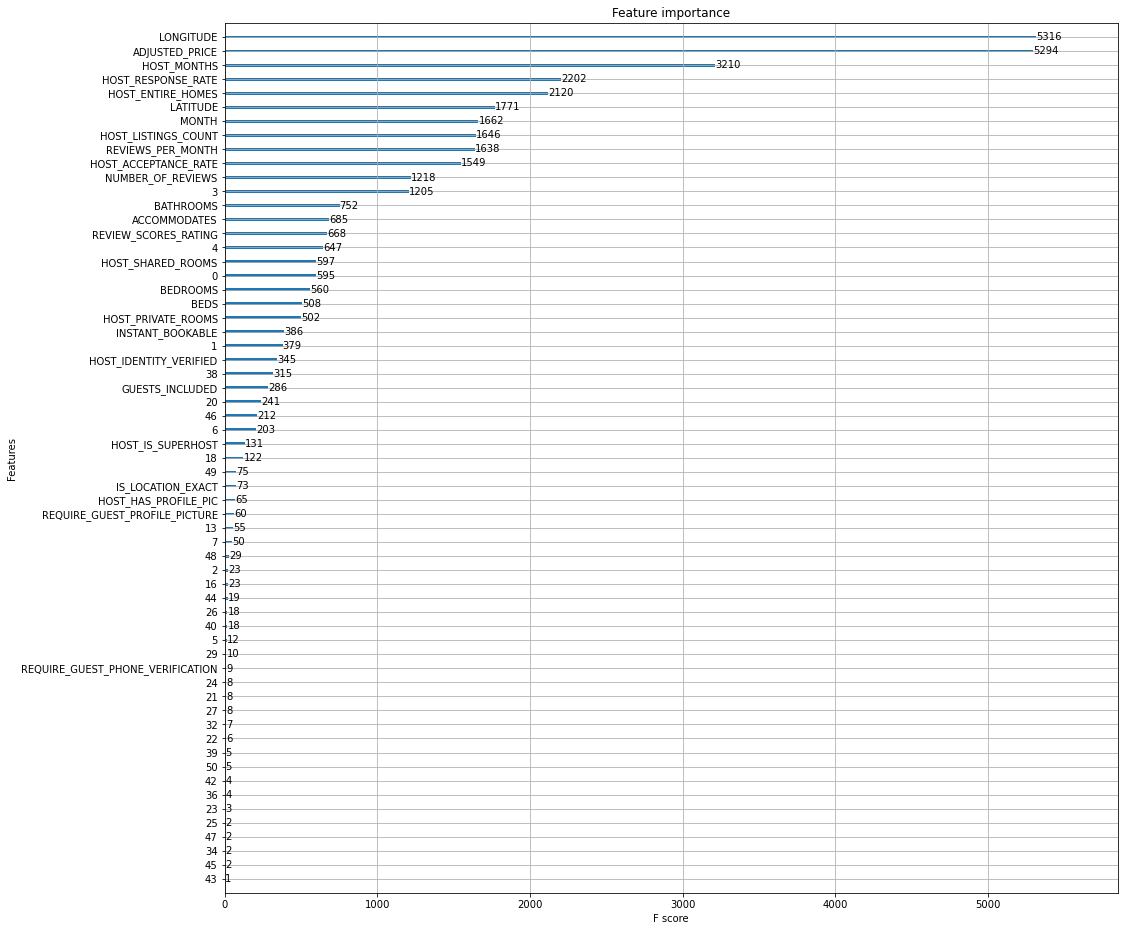

In [128]:
fig, ax = plt.subplots(figsize=(16, 16))
plot_importance(model1,ax=ax)

In [136]:
# # need to restart
# import os
# os.environ["PATH"] += os.pathsep + 'C:/Users/tyler/Anaconda3/Lib/site-packages/graphviz/'
#
# plot_tree(model1,ax=ax)
# to_graphviz(model1,ax=ax)

ExecutableNotFound: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

In [138]:
# for base, gobal model
# custom metrics to avoid negative pred/nan rsmle

def rmsle(predt, dtrain):
    ''' Root mean squared log error metric'''
    y = dtrain.get_label()
    predt[predt < -1] = -1 + 1e-6
    elements = np.power(np.log1p(y) - np.log1p(predt), 2)
    return 'RMSLE', float(np.sqrt(np.sum(elements) / len(y)))

model2 = XGBRegressor(n_estimators=1000,learning_rate = .01,random_state = 29)
print(model1)
model2.fit(df_train_ohe, y_train
           , eval_metric = rmsle
          , eval_set = [(df_train_ohe, y_train), (df_val_ohe, y_val)]
          , early_stopping_rounds = 20
          , verbose = True)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squaredlogerror', random_state=29, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
[0]	validation_0-rmse:20.26627	validation_1-rmse:21.42138	validation_0-RMSLE:2.32060	validation_1-RMSLE:2.24248
Multiple eval metrics have been passed: 'validation_1-RMSLE' will be used for early stopping.

Will train until validation_1-RMSLE hasn't improved in 20 rounds.
[1]	validation_0-rmse:20.10413	validation_1-rmse:21.26998	validation_0-RMSLE:2.22891	validation_1-RMSLE:2.16063


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=29,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

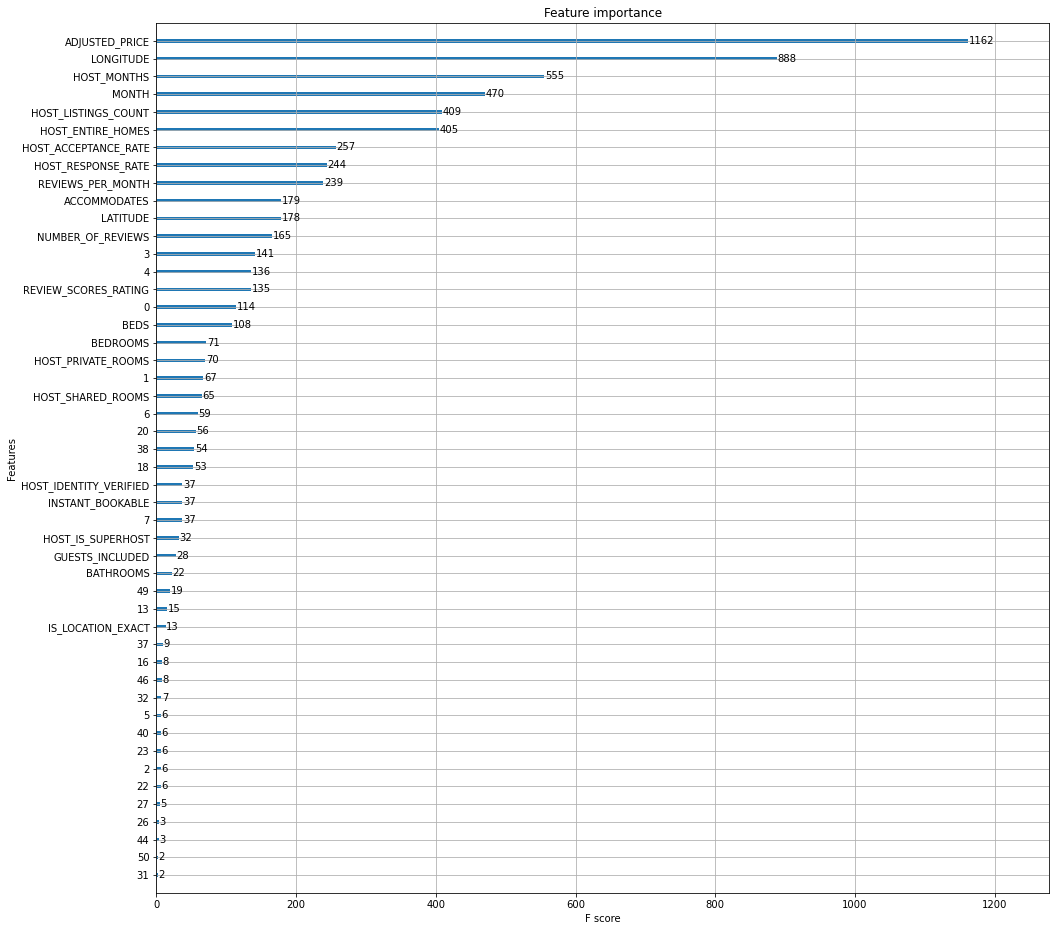

In [140]:
fig, ax = plt.subplots(figsize=(16, 16))
plot_importance(model2,ax=ax)

In [166]:
# train the model
# use Jun data as test
df_train_final, df_test_final, y_train_final, y_test_final, df_pred_final = split_data(df_base,'2020-06')
print(df_train_final.shape, df_test_final.shape,
      y_train_final.shape, y_test_final.shape,
      df_test_pred_final.shape)

(125388, 35) (23447, 35) (125388,) (23447,) (23447, 4)


In [167]:
cols_drop2 = ['ID','YEAR_MONTH']
for df in [df_train_final, df_test_final]:
    df.drop(cols_drop2, axis = 1, inplace = True)

# one hot encode
cols_cate = ['PROPERTY_TYPE','ROOM_TYPE','BED_TYPE','CANCELLATION_POLICY'
    ,'NEIGHBOURHOOD_CLEANSED']
X_train_final, X_test_final = encode_data(cols_cate, df_train_final, df_test_final)
print(df_train_ohe.shape, df_test_ohe.shape)

(101526, 79) (23447, 79)


In [168]:
# base model
model_xgbr = XGBRegressor(n_estimators=1000,learning_rate = .01,random_state = 29)
train_time,pred_time,base_model = train_and_eval_model(model_xgbr,X_train_final, y_train_final, X_test_final, df_pred_final)


Training time: 00:12:19
Predicting time: 00:00:01


In [169]:
print(base_model)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=29,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

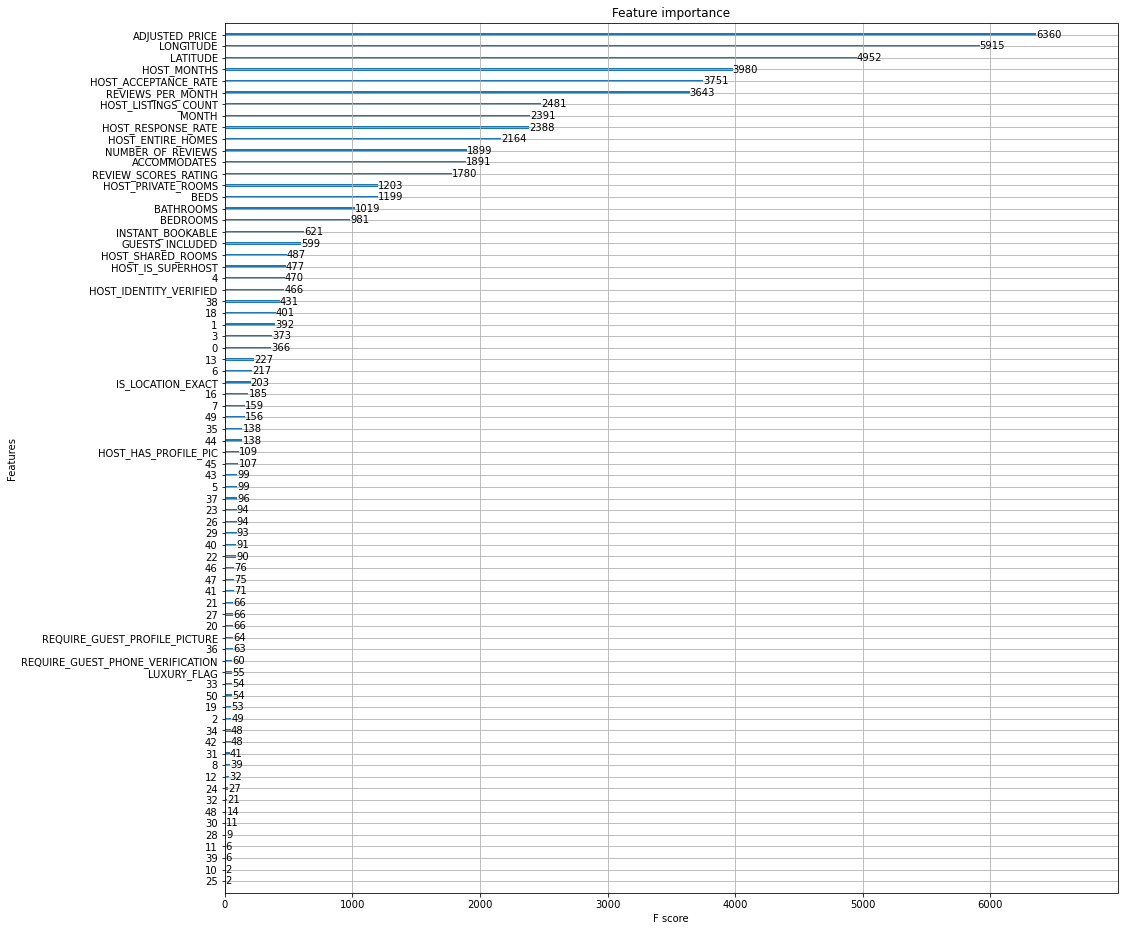

In [170]:
fig, ax = plt.subplots(figsize=(16, 16))
plot_importance(base_model, ax=ax)

In [171]:
import joblib
joblib.dump(base_model, "model/base_model.model")

['model/base_model.model']

In [172]:
train_time

739.88